In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
from scipy.stats import spearmanr, shapiro
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from scipy.optimize import curve_fit
import warnings
from IPython.core.display import display, HTML
import umap.umap_ as umap
import optuna

/tmp/ipykernel_343/405725717.py:14: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
df = pd.read_excel('../Dataset/simulation_data.xlsx')
df = df.iloc[:29]
first_row_values = df.iloc[0]
df.columns = list(first_row_values[:5]) + list(df.columns[5:])
df = df.iloc[2:, 1:]
df.drop(columns=['Zielwerte', 'Innoculum MiBi', 'Ablagerung \nRang', 'Prozess-\nparameter'], inplace=True)
df.set_index('Waschen', inplace=True)

df

,Temperatur,Konzentration des Desinfektionsmittels,Zeit,timestamp,oberflaechenspannung,uvenergie_mean,uvenergie_std,uvenergie_median,uvenergie_percentile25,uvenergie_percentile75,...,abs210_median,abs210_percentile25,abs210_percentile75,GH/KH_mean,GH/KH_std,GH/KH_median,GH/KH_percentile25,GH/KH_percentile75,Red KBE Mikrobiologie \n[log 10 KBE Reduziert],Energieverbrauch \n(ausgehend von Favorit plus nach Norm in kWh)
Waschen,,,,,,,,,,,,,,,,,,,,,
1,55,3,5,1.634027e+09,66.8,NaN,NaN,NaN,NaN,NaN,...,1.449664,1.448954,1.453887,0.0,0.00,1.0,1.0,2.0,6.130,0.30
2,55,1.6,60,1.634027e+09,66.2,NaN,NaN,NaN,NaN,NaN,...,0.191582,0.189564,0.193199,2.0,0.02,3.0,3.0,4.0,3.950,3.30
3,55,3,32.5,1.634027e+09,66.5,NaN,NaN,NaN,NaN,NaN,...,1.515012,1.507145,1.520853,4.0,0.04,5.0,5.0,6.0,6.330,1.50
4,40,2,5,1.634027e+09,69.1,NaN,NaN,NaN,NaN,NaN,...,0.251245,0.249950,0.253152,3.0,0.03,4.0,4.0,5.0,4.830,0.20
5,70,2,60,1.634651e+09,62.8,NaN,NaN,NaN,NaN,NaN,...,1.212803,1.210740,1.214665,0.0,0.00,1.0,1.0,2.0,5.197,4.80
6,70,3,32.5,1.634651e+09,63.1,NaN,NaN,NaN,NaN,NaN,...,1.662854,1.658027,1.670294,4.0,0.04,5.0,5.0,6.0,6.630,2.50
7,70,3,60,1.634824e+09,62.1,NaN,NaN,NaN,NaN,NaN,...,1.890761,1.887111,1.895173,3.0,0.03,4.0,4.0,5.0,7.030,4.80
8,40,2,32.5,1.634824e+09,68.7,NaN,NaN,NaN,NaN,NaN,...,2.065746,2.049112,2.074076,3.0,0.03,4.0,4.0,5.0,4.630,1.10
9,40,2,60,1.635338e+09,68.3,NaN,NaN,NaN,NaN,NaN,...,0.736664,0.734820,0.739086,1.0,0.01,2.0,2.0,3.0,4.470,2.50


In [3]:
df.columns

Index(['Temperatur', 'Konzentration des Desinfektionsmittels ', 'Zeit',
       'timestamp', 'oberflaechenspannung', 'uvenergie_mean', 'uvenergie_std',
       'uvenergie_median', 'uvenergie_percentile25', 'uvenergie_percentile75',
       ...
       'abs210_median', 'abs210_percentile25', 'abs210_percentile75',
       'GH/KH_mean', 'GH/KH_std', 'GH/KH_median', 'GH/KH_percentile25',
       'GH/KH_percentile75', 'Red KBE Mikrobiologie \n[log 10 KBE Reduziert]',
       'Energieverbrauch \n(ausgehend von Favorit plus nach Norm in kWh)'],
      dtype='object', length=102)

In [4]:
doe_analysis_df = df.iloc[:, [0, 1, 2, 4, -1, -2]].astype(float)

In [5]:
doe_analysis_df

,Temperatur,Konzentration des Desinfektionsmittels,Zeit,oberflaechenspannung,Energieverbrauch \n(ausgehend von Favorit plus nach Norm in kWh),Red KBE Mikrobiologie \n[log 10 KBE Reduziert]
Waschen,,,,,,
1,55.0,3.0,5.0,66.8,0.30,6.130
2,55.0,1.6,60.0,66.2,3.30,3.950
3,55.0,3.0,32.5,66.5,1.50,6.330
4,40.0,2.0,5.0,69.1,0.20,4.830
5,70.0,2.0,60.0,62.8,4.80,5.197
6,70.0,3.0,32.5,63.1,2.50,6.630
7,70.0,3.0,60.0,62.1,4.80,7.030
8,40.0,2.0,32.5,68.7,1.10,4.630
9,40.0,2.0,60.0,68.3,2.50,4.470


<Axes: >

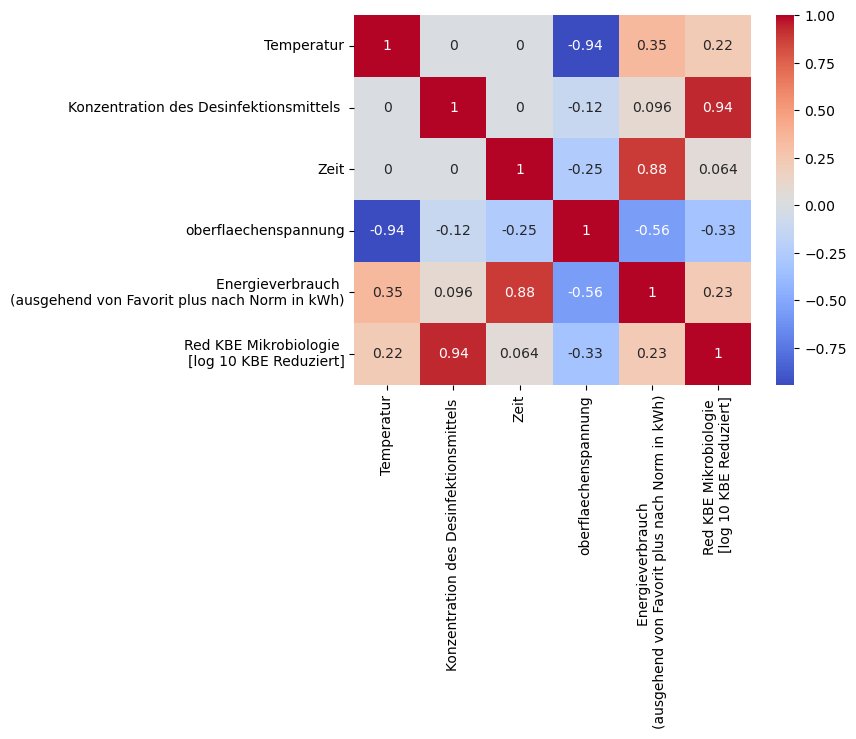

In [6]:
sns.heatmap(doe_analysis_df.corr(method='spearman'), cmap='coolwarm', annot=True)

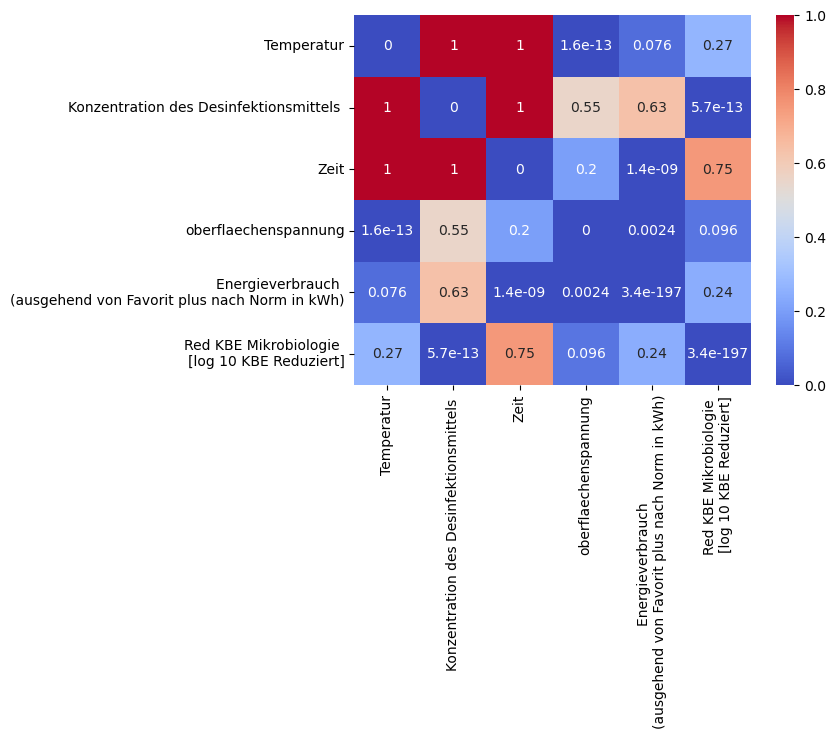

In [7]:
columns = doe_analysis_df.columns

p_values_df = pd.DataFrame(index=columns, columns=columns, dtype=float)
for col1 in columns:
    for col2 in columns:
        print()
        corr, p_value = spearmanr(doe_analysis_df[col1], doe_analysis_df[col2])
        p_values_df.loc[col1, col2] = p_value

sns.heatmap(p_values_df.astype(float), annot=True, cmap='coolwarm', vmin=0, vmax=1)

plt.show()

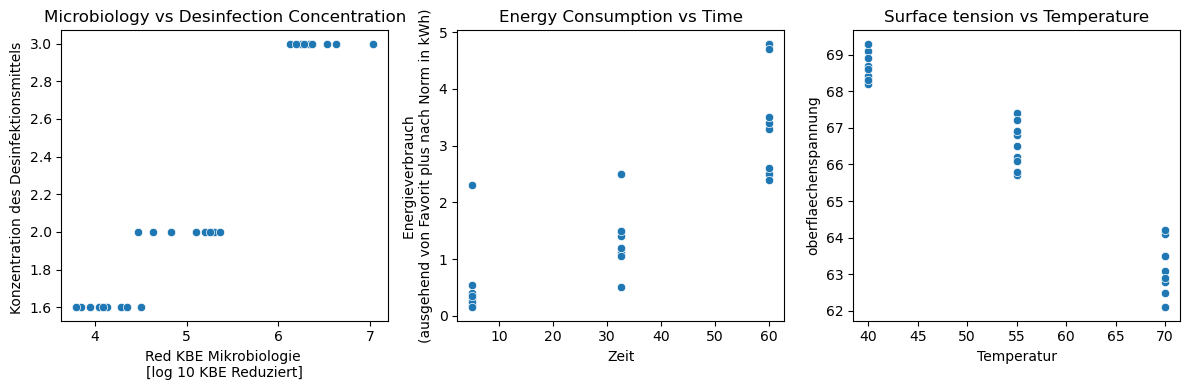

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
sns.scatterplot(data=doe_analysis_df, x=columns[-1], y=columns[1], ax=axes[0])
sns.scatterplot(data=doe_analysis_df, x=columns[2], y=columns[4], ax=axes[1])
sns.scatterplot(data=doe_analysis_df, x=columns[0], y=columns[3], ax=axes[2])
axes[0].set_title("Microbiology vs Desinfection Concentration")
axes[1].set_title("Energy Consumption vs Time")
axes[2].set_title("Surface tension vs Temperature")
plt.tight_layout()
plt.show()

/tmp/ipykernel_343/746739504.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(doe_analysis_df[columns[-1]], ax=axes[0])
/tmp/ipykernel_343/746739504.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(doe_analysis_df[columns[-2]], ax=axes[1])


Text(0.5, 1.0, 'SHAPIRO P_VALUE: 0.0099')

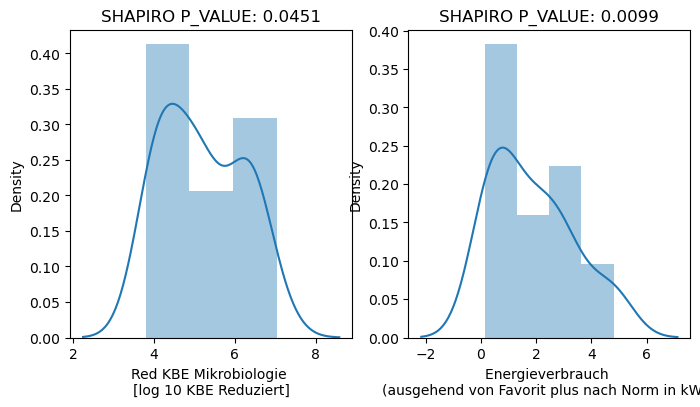

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
_, p_value1 = np.round(shapiro(doe_analysis_df[columns[-1]]), 4)
_, p_value2 = np.round(shapiro(doe_analysis_df[columns[-2]]), 4)
sns.distplot(doe_analysis_df[columns[-1]], ax=axes[0])
sns.distplot(doe_analysis_df[columns[-2]], ax=axes[1])
axes[0].set_title(f"SHAPIRO P_VALUE: {p_value1}")
axes[1].set_title(f"SHAPIRO P_VALUE: {p_value2}")

In [10]:
mean_columns = [col for col in df.columns if col.endswith('_mean')]
last_columns = list(df.columns[-2:])
filtered_columns = mean_columns + last_columns
means_analysis = df[filtered_columns]
means_analysis = means_analysis.iloc[:, 1:]
means_analysis.head()

,csbeq_mean,truebung_mean,chlor_mean,druck1_mean,fluss1_mean,ph1_mean,ph2_mean,ph3_mean,leitfaehigkeit2_mean,leitfaehigkeit3_mean,temperatur1_mean,Silikat_mean,abs254_mean,abs360_mean,abs210_mean,GH/KH_mean,Red KBE Mikrobiologie \n[log 10 KBE Reduziert],Energieverbrauch \n(ausgehend von Favorit plus nach Norm in kWh)
Waschen,,,,,,,,,,,,,,,,,,
1,376.504293,73.860339,1.46,0.128920,0.646489,7.227893,6.798377,6.866361,1907.202928,1954.314032,55.0,0.301404,0.343897,0.152711,1.453018,0.0,6.130,0.3
2,35.202265,13.569321,0.42,0.131843,0.643144,8.938785,9.854188,9.952730,815.873699,862.984803,56.0,0.501404,0.078265,0.046023,0.190993,2.0,3.950,3.3
3,430.223336,190.678602,1.85,0.125499,0.657584,7.196347,6.760775,6.828383,2332.804037,2379.915141,54.0,0.501479,0.311520,0.111962,1.483004,4.0,6.330,1.5
4,51.775323,15.655898,1.21,0.112713,0.657465,8.325633,7.491081,7.565992,1481.931936,1529.043040,42.0,0.301586,0.118074,0.066336,0.251421,3.0,4.830,0.2
5,343.266407,18.773334,0.81,0.125722,0.652089,8.300100,7.671189,7.747901,1605.978953,1653.090057,71.0,1.640023,0.281262,0.107112,1.216007,0.0,5.197,4.8


<Axes: >

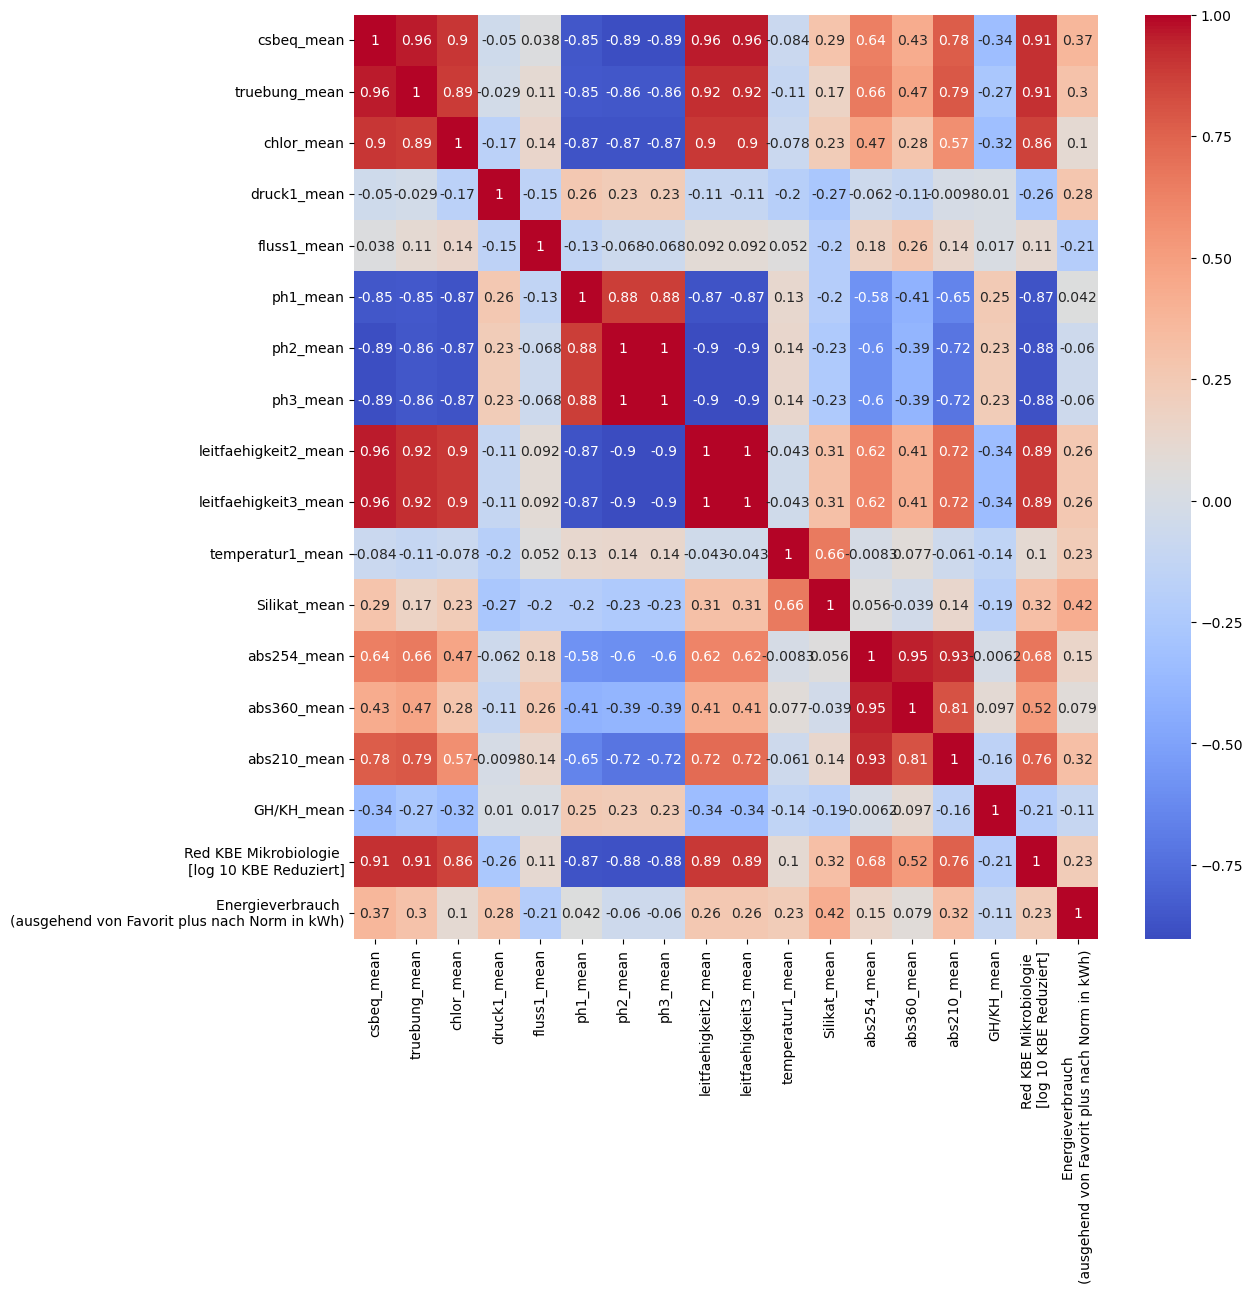

In [11]:
plt.figure(figsize=(12, 12))
sns.heatmap(means_analysis.corr(method='spearman'), annot=True, cmap='coolwarm')

In [12]:
target_cols = df.columns[-2:]
features = df.drop(list(target_cols) + ['uvenergie_mean', 'uvenergie_std', 
                   'uvenergie_median', 'uvenergie_percentile25', 'uvenergie_percentile75'], axis=1)

kfold = KFold(n_splits=5, random_state=42, shuffle=True)

mae1s = []
mae2s = []

for train_index, test_index in kfold.split(features):
    rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
    
    X_train, X_test = features.iloc[train_index], features.iloc[test_index]
    y_train, y_test = df[target_cols].iloc[train_index], df[target_cols].iloc[test_index]

    rf_regressor.fit(X_train, y_train)

    y_pred = rf_regressor.predict(X_test)

    y_pred1 = y_pred[:, 0]
    y_pred2 = y_pred[:, 1]

    y_true1 = y_test.iloc[:, 0]
    y_true2 = y_test.iloc[:, 1]

    mae1 = mean_absolute_error(y_true1, y_pred1)  
    mae2 = mean_absolute_error(y_true2, y_pred2)
    
    mae1s.append(mae1)
    mae2s.append(mae2)

avg_mae1 = np.mean(mae1s)
avg_mae2 = np.mean(mae2s)

print(f"Average MAE for '{target_cols[0]}': {avg_mae1:.2f}")
print(f"Average MAE for '{target_cols[1]}': {avg_mae2:.2f}")

Average MAE for 'Red KBE Mikrobiologie 
[log 10 KBE Reduziert]': 0.34
Average MAE for 'Energieverbrauch 
(ausgehend von Favorit plus nach Norm in kWh)': 0.98


In [13]:
df[target_cols].describe()

,Red KBE Mikrobiologie \n[log 10 KBE Reduziert],Energieverbrauch \n(ausgehend von Favorit plus nach Norm in kWh)
count,27.000000,27.000000
mean,5.188037,1.857407
std,1.000064,1.489754
min,3.800000,0.150000
25%,4.320000,0.450000
50%,5.197000,1.500000
75%,6.215000,2.550000
max,7.030000,4.800000


Text(0.5, 1.0, 'Random Forest Feature Importance')

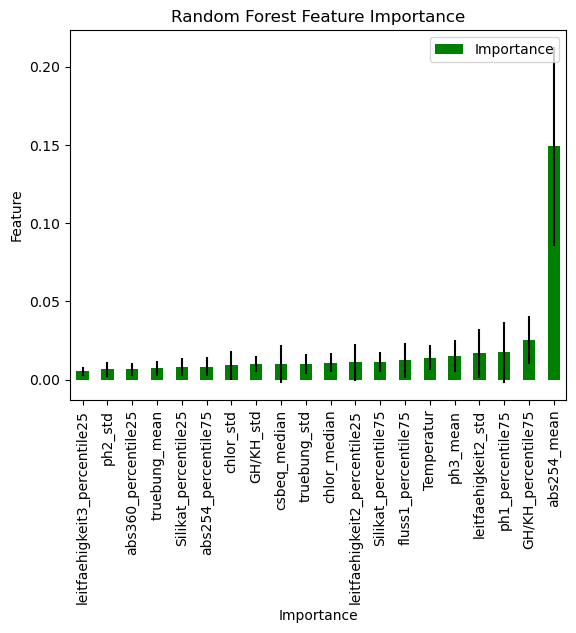

In [14]:
result = permutation_importance(rf_regressor, X_test, y_test, n_repeats=50, random_state=42)

perm_importances = result.importances_mean
perm_std = result.importances_std
sorted_idx = perm_importances.argsort()
feature_names = X_test.columns
importance = pd.DataFrame({'Importance': perm_importances, 'Std': perm_std}, index=feature_names[sorted_idx]).sort_values('Importance',ascending=False)
importance = importance[:20]

importance.sort_values(by='Importance', ascending=True, inplace=True)
importance.plot.bar(color='green', yerr='Std')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Random Forest Feature Importance")

In [15]:
importance

,Importance,Std
leitfaehigkeit3_percentile25,0.005327,0.002930
ph2_std,0.006480,0.004970
abs360_percentile25,0.006629,0.004123
truebung_mean,0.007094,0.004636
Silikat_percentile25,0.008131,0.005644
abs254_percentile75,0.008225,0.005886
chlor_std,0.009203,0.009192
GH/KH_std,0.009835,0.004983
csbeq_median,0.010031,0.012194
truebung_std,0.010065,0.006286


In [16]:
relationship_biology = {}
relationship_energy = {}
split_steps = 20
splits = np.linspace(0.05, 1, split_steps)
for iteration in range(split_steps):
    if iteration % 5 == 0:
        print("ITERATION:", iteration)
    split_size = splits[iteration]
    maes1 = []
    maes2 = []
    for j in range(100):
        X_train, X_test, y_train, y_test = train_test_split(features, df[target_cols], test_size=7)
        rf_regressor = RandomForestRegressor(n_estimators=100)
        if split_size==1:
            x, y = X_train, y_train
        else:
            x, _, y, _ = train_test_split(X_train, y_train, test_size=1-split_size)
        
        rf_regressor.fit(x, y)

        y_pred = rf_regressor.predict(X_test)
    
        y_pred1 = y_pred[:, 0]
        y_pred2 = y_pred[:, 1]

        y_true1 = y_test.iloc[:, 0]
        y_true2 = y_test.iloc[:, 1]

        mae1 = mean_absolute_error(y_true1, y_pred1)  
        mae2 = mean_absolute_error(y_true2, y_pred2)

        maes1.append(mae1)
        maes2.append(mae2)
    relationship_biology[split_size] = np.mean(maes1)
    relationship_energy[split_size] = np.mean(maes2)

ITERATION: 0
ITERATION: 5
ITERATION: 10
ITERATION: 15


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


ERROR AT DATASET SIZE MULTIPLIER 2: 0.3122520259792336


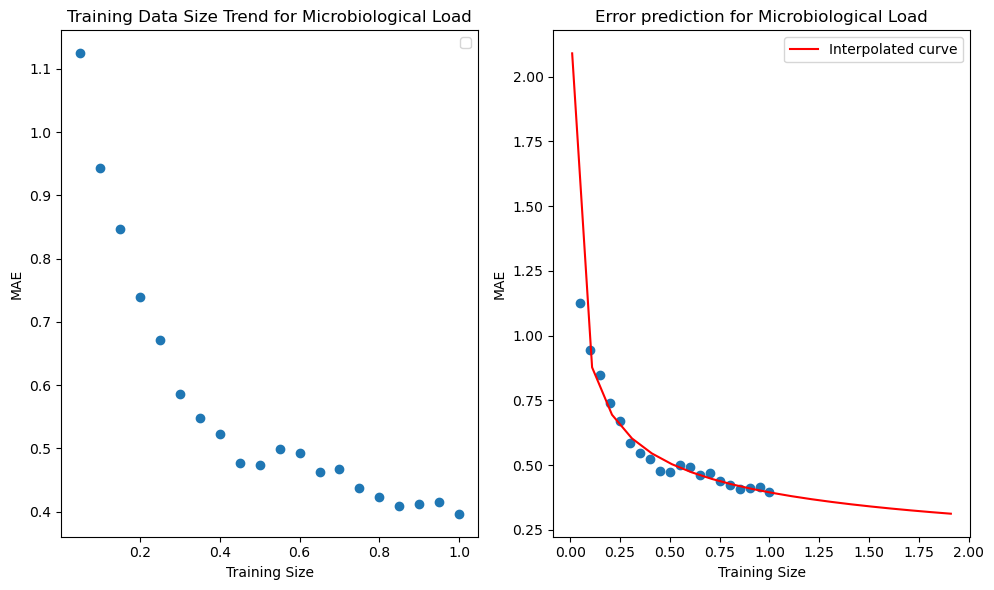

In [20]:
def make_estimate(data, name, dataset_size):
    x_axis = [float(i) for i in data.keys()]
    y_axis = [data[i] for i in data.keys()]

    fig, axes = plt.subplots(1, 2, figsize=(10, 6))

    axes[0].scatter(x_axis, y_axis, marker='o')
    axes[0].set_xlabel('Training Size')
    axes[0].set_ylabel('MAE')
    axes[0].set_title(f'Training Data Size Trend for {name}')

    def log_regression(x, a, b):
        return 10 ** (-a * np.log(x) + b)

    popt, pcov = curve_fit(log_regression, x_axis, y_axis)
    a = popt[0]
    b = popt[1]

    x_new = np.arange(0.01, 2, 0.1)
    y_new = log_regression(x_new, a, b)

    print(f'ERROR AT DATASET SIZE MULTIPLIER {dataset_size}: {min(y_new)}')

    axes[1].scatter(x_axis, y_axis, marker='o')
    axes[1].plot(x_new, y_new, color='red', label='Interpolated curve')
    axes[1].set_xlabel('Training Size')
    axes[1].set_ylabel('MAE')
    axes[1].set_title(f'Error prediction for {name}')

    for ax in axes:
        ax.legend()

    plt.tight_layout()

make_estimate(relationship_biology, 'Microbiological Load', 2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


ERROR AT DATASET SIZE MULTIPLIER 2: 0.9149254381886831


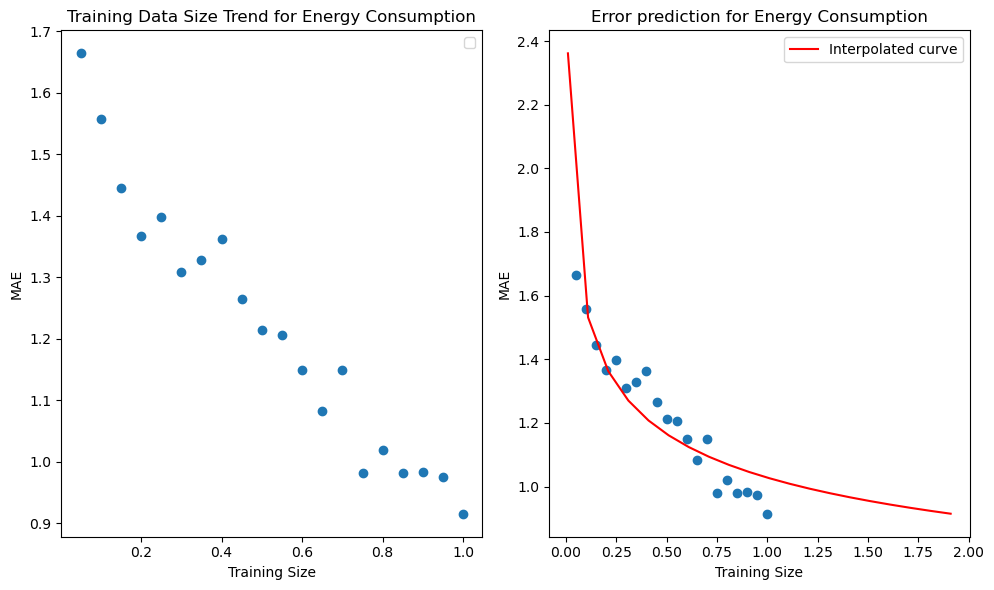

In [21]:
make_estimate(relationship_energy, 'Energy Consumption', 2)

In [22]:
warnings.simplefilter(action='ignore')
random_states_count = 100
target_cols = df.columns[-2:]
features = df.drop(list(target_cols) + ['uvenergie_mean', 'uvenergie_std', 
                   'uvenergie_median', 'uvenergie_percentile25', 'uvenergie_percentile75'], axis=1)

kfold = KFold(n_splits=9, random_state=42, shuffle=True)    


microbiology_cases = {'Case': [], 'Avg_Diff': []}
energy_cases = {'Case': [], 'Avg_Diff': []}

for train_index, test_index in kfold.split(features):
    diff_sum = np.zeros_like(y_test)

    for random_state in range(random_states_count):
        rf_regressor = RandomForestRegressor(n_estimators=100, random_state=random_state)
        
        X_train, X_test = features.iloc[train_index], features.iloc[test_index]
        y_train, y_test = df[target_cols].iloc[train_index], df[target_cols].iloc[test_index]

        rf_regressor.fit(X_train, y_train)

        y_pred = rf_regressor.predict(X_test)

        curr_diff = np.abs(np.array(y_test) - np.array(y_pred))
        diff_sum += curr_diff

    diff = diff_sum / random_states_count

    X_test['Microbiology_diff'] = diff[:, 0]
    X_test['Energy_diff'] = diff[:, 1]
    for i in range(3):
        microbiology_cases['Case'].append(X_test.sort_values(by='Microbiology_diff', ascending=False).reset_index().iloc[i]['Waschen'])
        energy_cases['Case'].append(X_test.sort_values(by='Energy_diff', ascending=False).reset_index().iloc[i]['Waschen'])

        microbiology_cases['Avg_Diff'].append(X_test.sort_values(by='Microbiology_diff', ascending=False).reset_index().iloc[i]['Microbiology_diff'])
        energy_cases['Avg_Diff'].append(X_test.sort_values(by='Energy_diff', ascending=False).reset_index().iloc[i]['Energy_diff'])


microbiology_cases_df = pd.DataFrame(microbiology_cases)
energy_cases_df = pd.DataFrame(energy_cases)


In [23]:
def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

In [24]:
display_side_by_side([microbiology_cases_df.sort_values(by='Avg_Diff', ascending=False).reset_index(drop=True), energy_cases_df.sort_values(by='Avg_Diff', ascending=False).reset_index(drop=True)], captions=['Microbiology Cases', 'Energy Consumption Cases'])

,Case,Avg_Diff
0,7,1.345988
1,9,0.696828
2,24,0.665417
3,8,0.636280
4,6,0.566783
5,16,0.561321
6,21,0.540601
7,26,0.497338
8,23,0.484643
9,22,0.462181


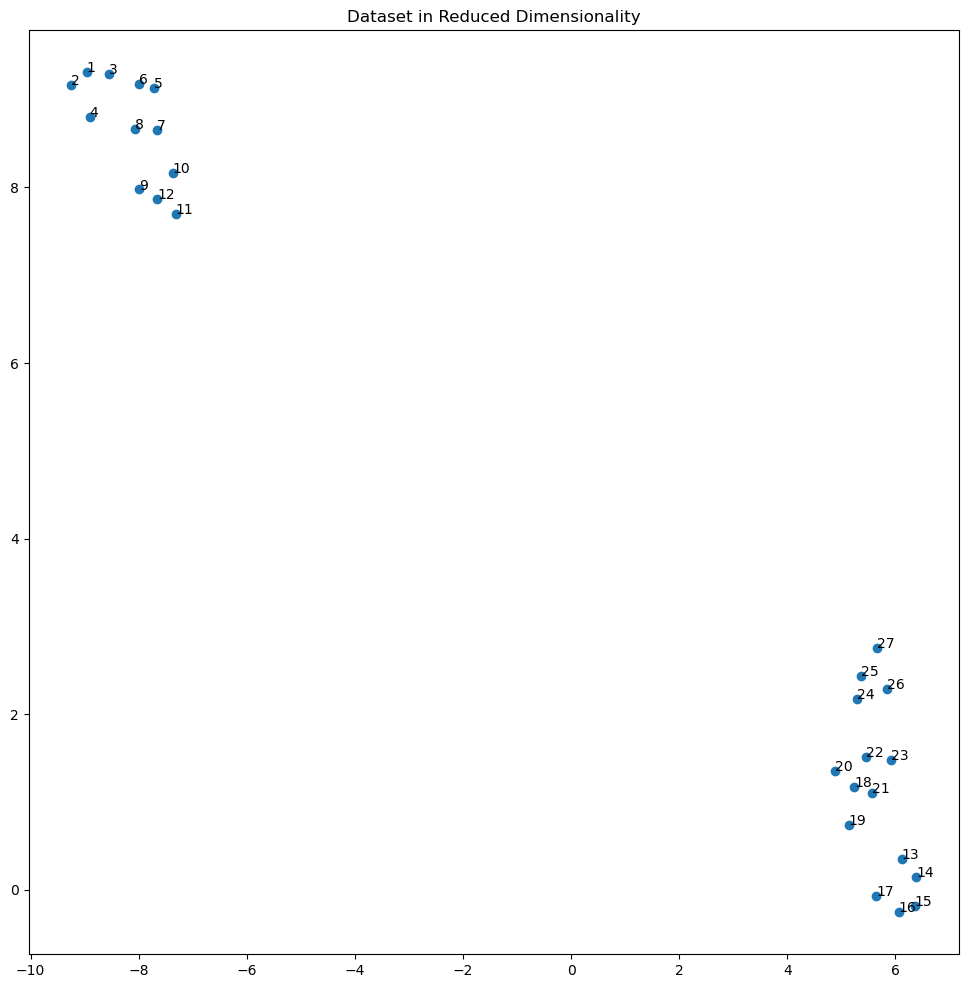

In [25]:
umap_obj = umap.UMAP(n_components=2, random_state=42)
projected_data = umap_obj.fit_transform(df.dropna(axis=1))
plt.figure(figsize=(12, 12))
plt.scatter(projected_data[:, 0], projected_data[:, 1])
for i in range(1, 28):
    plt.annotate(str(i), (projected_data[i-1, 0], projected_data[i-1, 1]))
plt.title("Dataset in Reduced Dimensionality")
plt.show()

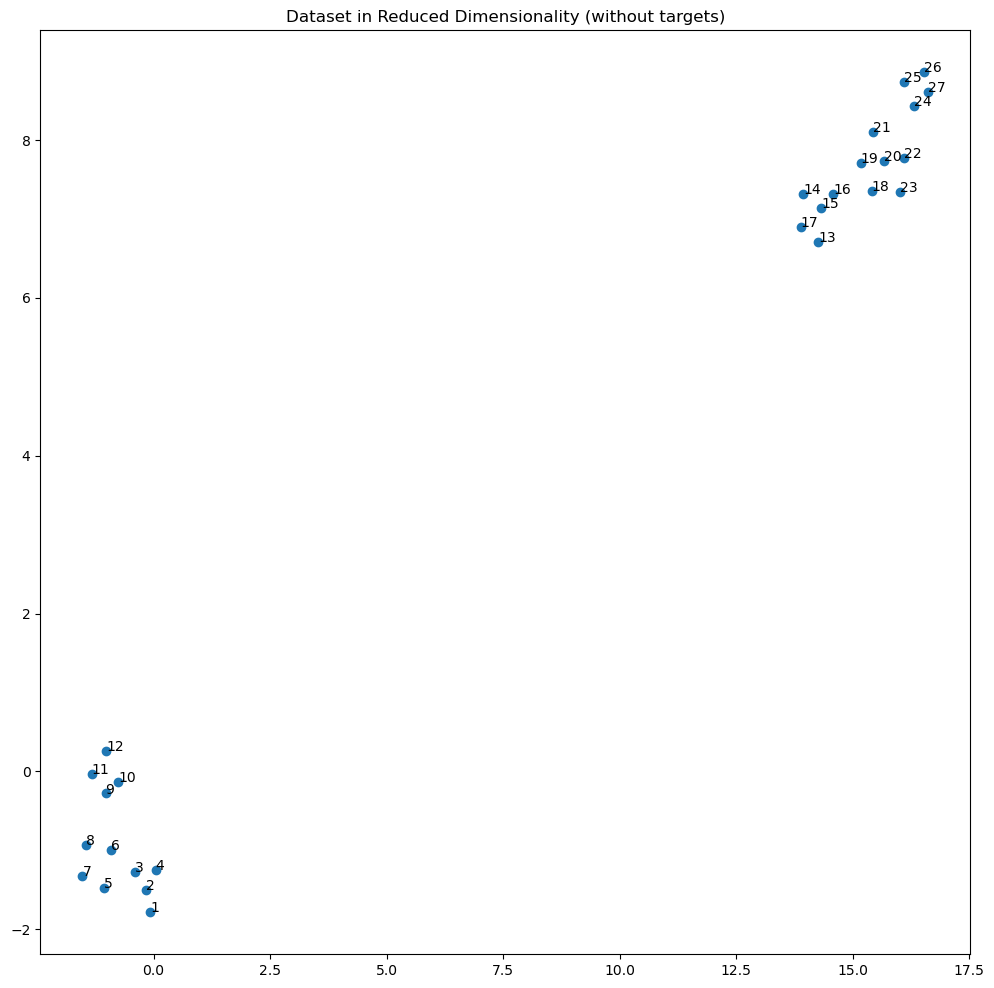

In [26]:
umap_obj = umap.UMAP(n_components=2, random_state=40)
projected_data = umap_obj.fit_transform(df.dropna(axis=1).iloc[:, :-2])
plt.figure(figsize=(12, 12))
plt.scatter(projected_data[:, 0], projected_data[:, 1]) 
for i in range(1, 28):
    plt.annotate(str(i), (projected_data[i-1, 0], projected_data[i-1, 1]))
plt.title("Dataset in Reduced Dimensionality (without targets)")
plt.show()

In [27]:
def objective(trial):
        """
        Objective function for Optuna hyperparameter optimization.

        Args:
            trial (optuna.Trial): Optuna trial object.

        Returns:
            float: Mean absolute error (MAE) for the model.
        """
        mae_list = []
        k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

        for train_idx, val_idx in k_fold.split(X_train, y_train):
            model = RandomForestRegressor(
                n_estimators=trial.suggest_int("n_estimators", 5, 1000),
                max_depth=trial.suggest_int("max_depth", 3, 50),
                min_samples_split=trial.suggest_int("min_samples_split", 2, 30),
                min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 15),
                max_features=trial.suggest_float("max_features", 0.1, 1),
                bootstrap=trial.suggest_categorical("bootstrap", [True, False]),
            )

            x_train_fold, x_val_fold = (
                X_train[train_idx],
                X_train[val_idx],
            )
            y_train_fold, y_val_fold = (
                y_train[train_idx],
                y_train[val_idx],
            )

            model.fit(x_train_fold, y_train_fold)
            predictions = model.predict(x_val_fold)


            mae = mean_absolute_error(
                y_val_fold, predictions, multioutput="raw_values"
            )

            target_average_mae = np.mean(mae)

            mae_list.append(target_average_mae)

        return np.mean(mae_list)

In [28]:
X_test = np.array(features.iloc[[6, 4, 8, 10, 23, 18]])
y_test = np.array(df.iloc[[6, 4, 8, 10, 23, 18], -2:])

In [29]:
X_train = np.array(features.iloc[[0, 1, 2, 3, 5, 7, 9, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 24, 25, 26]])
y_train = np.array(df.iloc[[0, 1, 2, 3, 5, 7, 9, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 24, 25, 26], -2:])

In [30]:
sampler = optuna.samplers.TPESampler(seed=42, n_startup_trials=35)
study = optuna.create_study(direction="minimize", sampler=sampler)
study.optimize(objective, n_trials=100, show_progress_bar=True)

params = study.best_params
model = RandomForestRegressor(**params)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

y_pred1 = y_pred[:, 0]
y_pred2 = y_pred[:, 1]

y_true1 = y_test[:, 0]
y_true2 = y_test[:, 1]

mae1 = mean_absolute_error(y_true1, y_pred1)  
mae2 = mean_absolute_error(y_true2, y_pred2)

print(mae1, mae2)

[I 2024-01-08 16:23:50,220] A new study created in memory with name: no-name-c48f445c-6859-4ea8-8678-968fb29567d7


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-01-08 16:23:51,317] Trial 0 finished with value: 0.9573039312947402 and parameters: {'n_estimators': 378, 'max_depth': 48, 'min_samples_split': 23, 'min_samples_leaf': 9, 'max_features': 0.24041677639819287, 'bootstrap': True}. Best is trial 0 with value: 0.9573039312947402.
[I 2024-01-08 16:23:53,657] Trial 1 finished with value: 0.9565238533821828 and parameters: {'n_estimators': 867, 'max_depth': 31, 'min_samples_split': 22, 'min_samples_leaf': 1, 'max_features': 0.9729188669457949, 'bootstrap': True}. Best is trial 1 with value: 0.9565238533821828.
[I 2024-01-08 16:23:54,068] Trial 2 finished with value: 0.7436997535842298 and parameters: {'n_estimators': 186, 'max_depth': 11, 'min_samples_split': 10, 'min_samples_leaf': 8, 'max_features': 0.48875051677790415, 'bootstrap': False}. Best is trial 2 with value: 0.7436997535842298.
[I 2024-01-08 16:23:54,379] Trial 3 finished with value: 0.7447238095238105 and parameters: {'n_estimators': 143, 'max_depth': 17, 'min_samples_spli

In [31]:
print(np.abs(y_pred-y_test))

[[0.62673295 2.25919508]
 [0.34392045 3.49469697]
 [0.27197917 1.46324811]
 [0.16320644 2.8365625 ]
 [0.89429735 1.93481061]
 [0.43542045 0.85300189]]


In [32]:
display_side_by_side([microbiology_cases_df.sort_values(by='Avg_Diff', ascending=False).reset_index(drop=True), energy_cases_df.sort_values(by='Avg_Diff', ascending=False).reset_index(drop=True)], captions=['Microbiology Cases', 'Energy Consumption Cases'])

,Case,Avg_Diff
0,7,1.345988
1,9,0.696828
2,24,0.665417
3,8,0.636280
4,6,0.566783
5,16,0.561321
6,21,0.540601
7,26,0.497338
8,23,0.484643
9,22,0.462181


Text(0.5, 1.0, 'Random Forest Feature Importance')

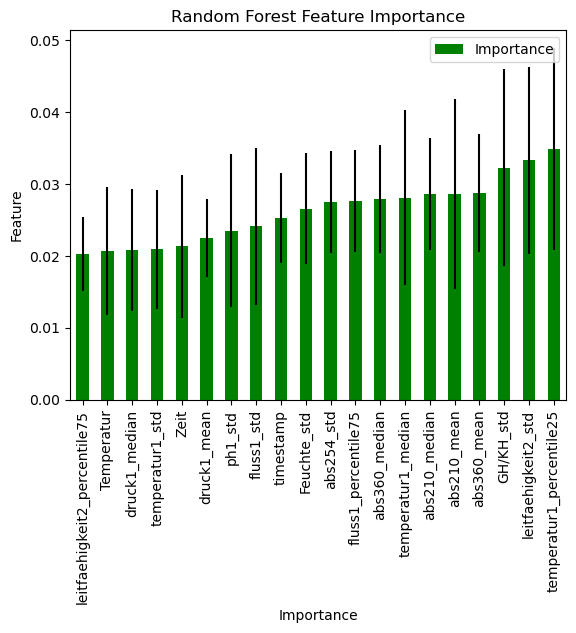

In [33]:
result = permutation_importance(model, X_test, y_test, n_repeats=50, random_state=42)

perm_importances = result.importances_mean
perm_std = result.importances_std
sorted_idx = perm_importances.argsort()
feature_names = features.columns
importance = pd.DataFrame({'Importance': perm_importances, 'Std': perm_std}, index=feature_names[sorted_idx]).sort_values('Importance',ascending=False)
importance = importance[:20]

importance.sort_values(by='Importance', ascending=True, inplace=True)
importance.plot.bar(color='green', yerr='Std')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Random Forest Feature Importance")